In [1]:
!pip install tweepy apyori networkx

import pandas as pd
import tweepy
import networkx as nx
import matplotlib.pyplot as plt
from lib import progress_bar
import json
import re
from collections import Counter
from apyori import apriori

import warnings
warnings.filterwarnings("ignore")

In [2]:
CONSUMER_KEY = "{YOUR_API_KEY}"
CONSUMER_SECRET = "{YOUR_API_SECRET_KEY}"
ACCESS_TOKEN_KEY = "{YOUR_ACCESS_TOKEN}"
ACCESS_TOKEN_SECRET = "{YOUR_ACCESS_TOKEN_SECRET}"
  
# Opening JSON file
with open('api_config.json','r') as f:
    config = json.load(f)
    CONSUMER_KEY = config['CONSUMER_KEY']
    CONSUMER_SECRET = config['CONSUMER_SECRET']
    ACCESS_TOKEN_KEY = config['ACCESS_TOKEN_KEY']
    ACCESS_TOKEN_SECRET = config['ACCESS_TOKEN_SECRET']

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN_KEY, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

In [3]:
KEYWORD = "programming" # Keyword we want to analyze using Twitter API

Collect Data using Twitter API

In [4]:
tweets = api.search(KEYWORD)
columns = ['created', 'tweet_text']
df = pd.DataFrame(columns = columns)
print("Getting Data...")
dataSize = 100
for i in range(dataSize):
    tweets = api.search(KEYWORD)
    for tweet in tweets:
        tweet_text = tweet.text
        created = tweet.created_at
        row = [created, tweet_text]
        series = pd.Series(row, index = df.columns)
        df = df.append(series, ignore_index = True)
    progress_bar.progress_bar(i, dataSize)
progress_bar.progress_bar(dataSize, dataSize)
print("\nGetting Data Completed...")
df.head(3)

Getting Data...
[====================================================================================================] 100%
Getting Data Completed...


,created,tweet_text
0,2021-08-11 04:43:56,RT @Synapsesaillc: Microsoft Cloud for Healthc...
1,2021-08-11 04:43:53,"RT @ctrl_sh1ft: hiiii, #studytwt #lifetwt \n\n..."
2,2021-08-11 04:43:52,"RT @MarkRuffalo: Can’t wait to see it, @TaikaW..."


Extract Keywords

In [5]:
def text_cleaning(text):
    regex = re.compile('[^ A-Za-z]+') # For English
    result = regex.sub('', text)
    return result

df['clean_text'] = df['tweet_text'].apply(lambda x : text_cleaning(x))
df.head()

,created,tweet_text,clean_text
0,2021-08-11 04:43:56,RT @Synapsesaillc: Microsoft Cloud for Healthc...,RT Synapsesaillc Microsoft Cloud for Healthcar...
1,2021-08-11 04:43:53,"RT @ctrl_sh1ft: hiiii, #studytwt #lifetwt \n\n...",RT ctrlshft hiiii studytwt lifetwt Im Zari sh...
2,2021-08-11 04:43:52,"RT @MarkRuffalo: Can’t wait to see it, @TaikaW...",RT MarkRuffalo Cant wait to see it TaikaWaitit...
3,2021-08-11 04:43:43,"citra - dance, her own style of capoeira , her...",citra dance her own style of capoeira her gr...
4,2021-08-11 04:43:36,RT @pomracenje_: Programmers when programming ...,RT pomracenje Programmers when programming the...


In [6]:
# Other languages' stopwords available here: https://www.ranks.nl/stopwords
stopwords_path = "data/english_stopwords.txt" # For English

with open(stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

In [7]:
def get_nouns(x):
    words = list(x.split())
    # Remove words shorter or equal to length of 2 and remove stopwords
    nouns = [word for word in words if len(word) > 2 and word not in stopwords]
    return nouns

In [8]:
df['nouns'] = df['clean_text'].apply(lambda x : get_nouns(x))
print(df.shape)
df.head(3)

(1500, 4)


,created,tweet_text,clean_text,nouns
0,2021-08-11 04:43:56,RT @Synapsesaillc: Microsoft Cloud for Healthc...,RT Synapsesaillc Microsoft Cloud for Healthcar...,"[Synapsesaillc, Microsoft, Cloud, Healthcare, ..."
1,2021-08-11 04:43:53,"RT @ctrl_sh1ft: hiiii, #studytwt #lifetwt \n\n...",RT ctrlshft hiiii studytwt lifetwt Im Zari sh...,"[ctrlshft, hiiii, studytwt, lifetwt, Zari, she..."
2,2021-08-11 04:43:52,"RT @MarkRuffalo: Can’t wait to see it, @TaikaW...",RT MarkRuffalo Cant wait to see it TaikaWaitit...,"[MarkRuffalo, Cant, wait, see, TaikaWaititi, F..."


In [9]:
transactions = df['nouns'].tolist()
transactions = [transaction for transaction in transactions if transaction]
print(transactions[:3])

[['Synapsesaillc', 'Microsoft', 'Cloud', 'Healthcare', 'expands', 'portfolio', 'Azure', 'Healthcare', 'APIsFor', 'info', 'visit', 'httpstcoUsKXEgf'], ['ctrlshft', 'hiiii', 'studytwt', 'lifetwt', 'Zari', 'sheher', 'istpt', 'currently', 'enrolled', 'ICT', 'studentlikes', 'stationery', 'journa'], ['MarkRuffalo', 'Cant', 'wait', 'see', 'TaikaWaititi', 'Finally', 'More', 'First', 'People', 'programming']]


Analyze Keyword using Association Rule

In [17]:
# Setup your own apriori settings based on the keyword for best representation
results = list(apriori(transactions, min_support=0.1, min_confidence=0.3, min_lift=1, max_length=2))
print(results[:3])
#results = list(apriori(transactions,min_support=0.05,min_confidence=0.1,min_lift=5,max_length=2))

[RelationRecord(items=frozenset({'DaysOfCode'}), support=0.3255172413793103, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'DaysOfCode'}), confidence=0.3255172413793103, lift=1.0)]), RelationRecord(items=frozenset({'programming'}), support=0.31310344827586206, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'programming'}), confidence=0.31310344827586206, lift=1.0)]), RelationRecord(items=frozenset({'Basic', 'AlkayalWajdi'}), support=0.12, ordered_statistics=[OrderedStatistic(items_base=frozenset({'AlkayalWajdi'}), items_add=frozenset({'Basic'}), confidence=1.0, lift=8.333333333333334), OrderedStatistic(items_base=frozenset({'Basic'}), items_add=frozenset({'AlkayalWajdi'}), confidence=1.0, lift=8.333333333333334)])]


In [20]:
columns = ['source', 'target', 'support']
network_df = pd.DataFrame(columns = columns)

for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        row = [items[0], items[1], result.support]
        series = pd.Series(row, index = network_df.columns)
        network_df = network_df.append(series, ignore_index=True)

network_df.head()

(75, 3)

In [21]:
tweet_corpus = ''.join(df['clean_text'].tolist())
print(tweet_corpus[:500])

RT Synapsesaillc Microsoft Cloud for Healthcare expands portfolio with Azure Healthcare APIsFor more info visit httpstcoUsKXEgfRT ctrlshft hiiii studytwt lifetwt  Im Zari sheher  istpt currently enrolled as an ICT studentlikes stationery journaRT MarkRuffalo Cant wait to see it TaikaWaititi Finally More First People programmingcitra  dance her own style of capoeira  her graceful movements juxtaposing her brash personalityselene  knife httpstcoIsRpVnQRT pomracenje Programmers when programming the


In [24]:
nouns =  get_nouns(tweet_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
node_df = pd.DataFrame(remove_char_counter.items(), columns = ['node', 'nodesize'])

node_df = node_df[node_df['nodesize'] >= 100]
node_df.head()

,node,nodesize
3,Healthcare,148
24,MarkRuffalo,124
25,Cant,124
26,wait,124
27,see,124


Visualize Keyword Network

In [25]:
def drawNetwork(G, node_df, plt):
    for idx, row in node_df.iterrows():
        G.add_node(row['node'], nodesize=row['nodesize'])
    for idx, row in network_df.iterrows():
        G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])
    pos = nx.spring_layout(G, k=0.6, iterations=50)
    sizes = [G.nodes[node]['nodesize']*25 for node in G]
    nx.draw(G, pos=pos, node_size=sizes)
    nx.draw_networkx_labels(G, pos=pos, font_family='AppleGothic', font_size=25)
    ax = plt.gca()
    plt.show()

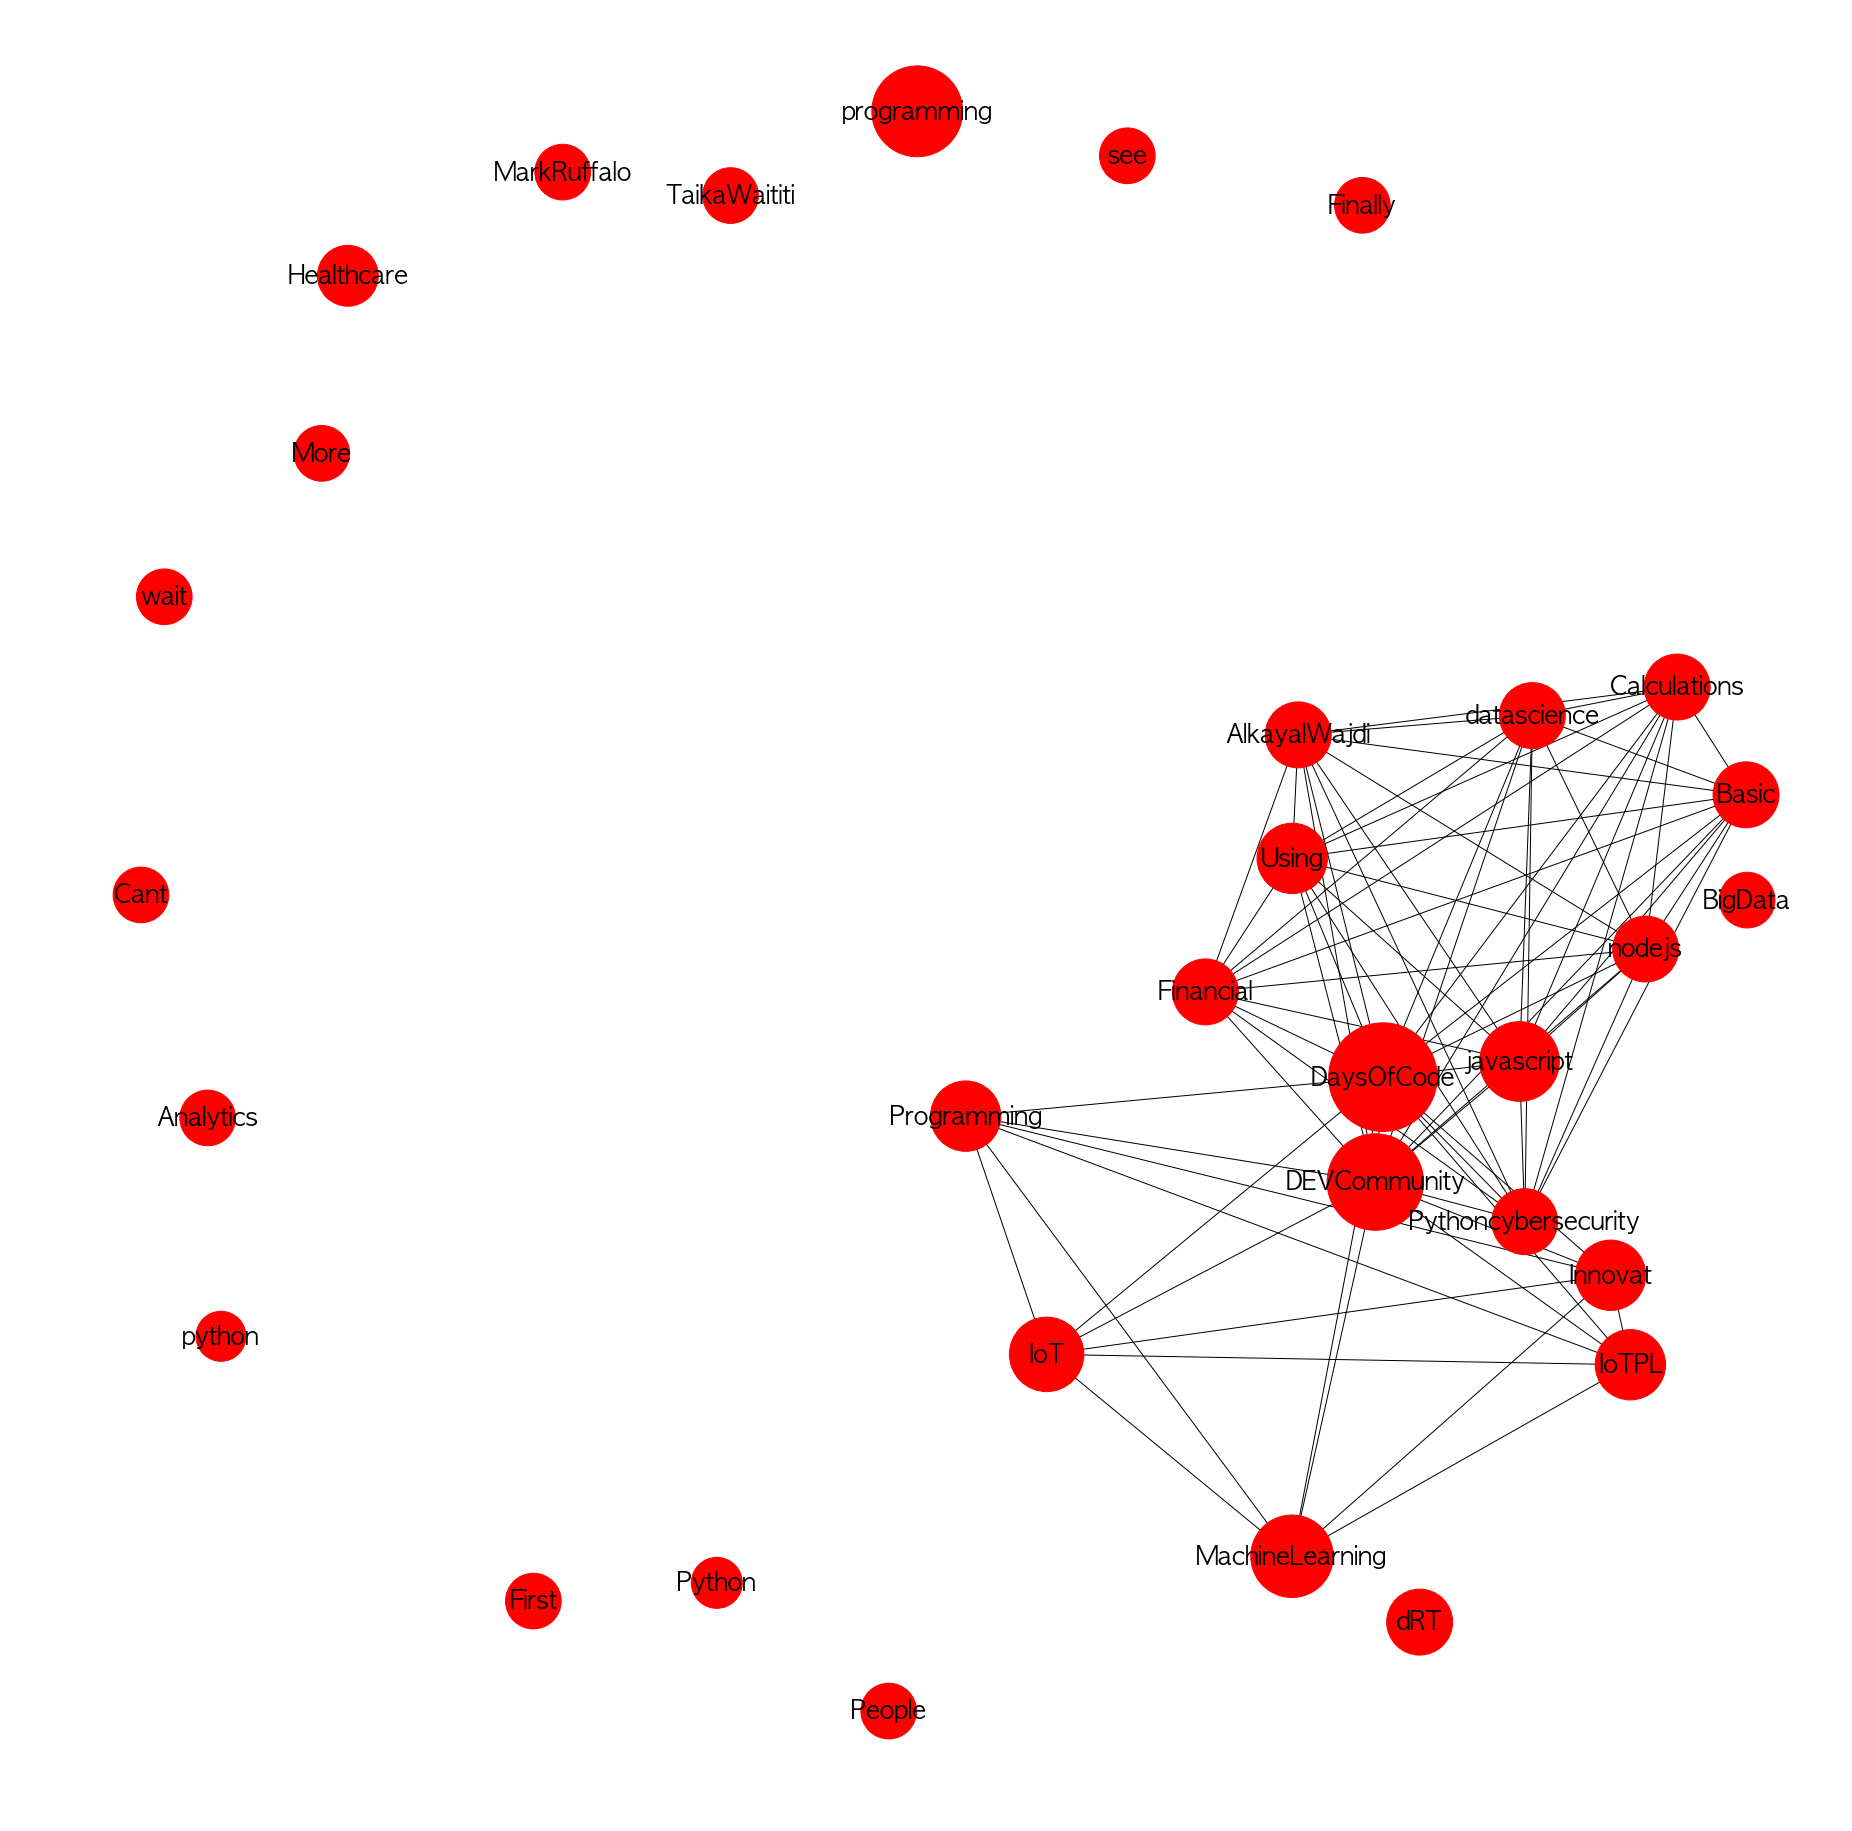

In [26]:
plt.figure(figsize=(25,25))
G = nx.Graph()
drawNetwork(G, node_df, plt)